In [2]:
# import dependencies
# import sys
# !{sys.executable} -m pip install mpl-scatter-density
# import matplotlib as mplt
import matplotlib.pyplot as plt
import tensorflow as tf
# from tensorflow import keras
import pandas as pd
import glacierml as gl
import numpy as np
from scipy.stats import gaussian_kde
from tqdm import tqdm
import os
tf.random.set_seed(42)

pd.set_option('display.max_columns', None)

parameterization = '4'

RS = range(0,25,1)

print('currently running tensorflow version: ' + tf.__version__)

2023-08-22 08:26:50.573257: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-22 08:26:50.623220: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-22 08:26:51.337710: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


currently running tensorflow version: 2.12.0


In [4]:
parameterization = '4'
if parameterization == '1':
    threshold = 'No Threshold'
if parameterization == '2':
    threshold = '0.25'
if parameterization == '3':
    threshold = '0.50'
if parameterization == '4':
    threshold = '0.75'
dataset = gl.parameterize_data(parameterization)
dataset

2.0.0


,RGIId,CenLat,CenLon,Slope,Zmin,Zmed,Zmax,Area,Aspect,Lmax,Thickness
0,RGI60-01.00037,63.469173,-146.528168,12.0,722,1841,3081,234.583,30,41911,235.0
1,RGI60-01.00570,63.281000,-145.427000,14.0,1162,1858,2438,17.567,172,8639,147.0
2,RGI60-01.01104,58.380000,-134.349000,10.0,676,1123,1494,9.528,327,6332,66.0
8,RGI60-01.16374,61.200000,-140.302000,14.0,2145,2509,2894,5.859,341,3374,66.0
9,RGI60-02.03411,51.177000,-116.330000,15.3,2390,2526,2853,0.872,69,1181,70.0
...,...,...,...,...,...,...,...,...,...,...,...
489,RGI60-17.14088,-33.029600,-70.098400,29.0,2929,5121,5894,8.376,358,8560,59.0
490,RGI60-17.14647,-30.145400,-69.927600,29.3,4664,5187,5525,1.189,148,1596,28.0
491,RGI60-17.15038,-28.538700,-69.731800,16.0,4784,5234,5597,3.140,190,3349,39.0
492,RGI60-17.15087,-28.381400,-69.609100,11.6,5068,5406,5753,5.209,79,3782,67.0


In [5]:
# load deviations table 
rootdir = 'temp/'
predictions = pd.DataFrame()
stats1 = pd.read_pickle(rootdir + 'model_statistics_mae_' + parameterization + '.pkl')
stats1['parameter ratio'] = stats1['trained parameters'] / stats1['inputs']

stats2 = pd.read_pickle(rootdir + 'model_statistics_mse_' + parameterization + '.pkl')
stats2['parameter ratio'] = stats2['trained parameters'] / stats2['inputs']

In [6]:
# load deviations table 
rootdir = 'zults/'
predictions = pd.DataFrame()
stats1 = pd.read_pickle(rootdir + 'model_statistics_' + parameterization + '.pkl')

# statistics = statistics.drop('Unnamed: 0', axis = 1)
stats1['total parameters'] = stats1['total parameters'].astype(int)
stats1['trained parameters'] = stats1['trained parameters'].astype(int)
stats1['total inputs'] = stats1['total inputs'].astype(int)
# statistics_mae['test - train'] = (
#     abs(statistics_mse['test mae avg'] - statistics_mae['train mae avg']))
stats1['parameter ratio'] = stats1['trained parameters'] / stats1['total inputs']
stats1

,layer architecture,total parameters,trained parameters,total inputs,test mae avg,train mae avg,test mae std dev,train mae std dev,architecture weight 1,architecture weight 2,parameter ratio
0,3-2,60,41,3069,17.888150,18.320922,4.794239,3.915898,145.110860,0.006891,0.013359
1,4-2,72,53,3069,19.495260,19.487580,5.440397,4.502279,133.148514,0.007510,0.017269
2,5-2,84,65,3069,16.948900,17.207373,4.296981,3.105293,153.152412,0.006529,0.021180
3,6-2,96,77,3069,17.472450,17.441128,5.753468,3.278046,148.563301,0.006731,0.025090
4,7-2,108,89,3069,18.054400,18.706029,4.467628,4.463059,143.774640,0.006955,0.029000
...,...,...,...,...,...,...,...,...,...,...,...
156,16-15,450,431,3069,15.679167,16.010148,3.222594,0.768343,165.555028,0.006040,0.140437
157,17-15,475,456,3069,15.743689,16.066999,3.108120,0.780996,164.876527,0.006065,0.148583
158,18-15,500,481,3069,15.769674,16.090924,3.054389,0.852239,164.604852,0.006075,0.156729
159,19-15,525,506,3069,15.665721,16.042760,3.150946,0.752430,165.697122,0.006035,0.164875


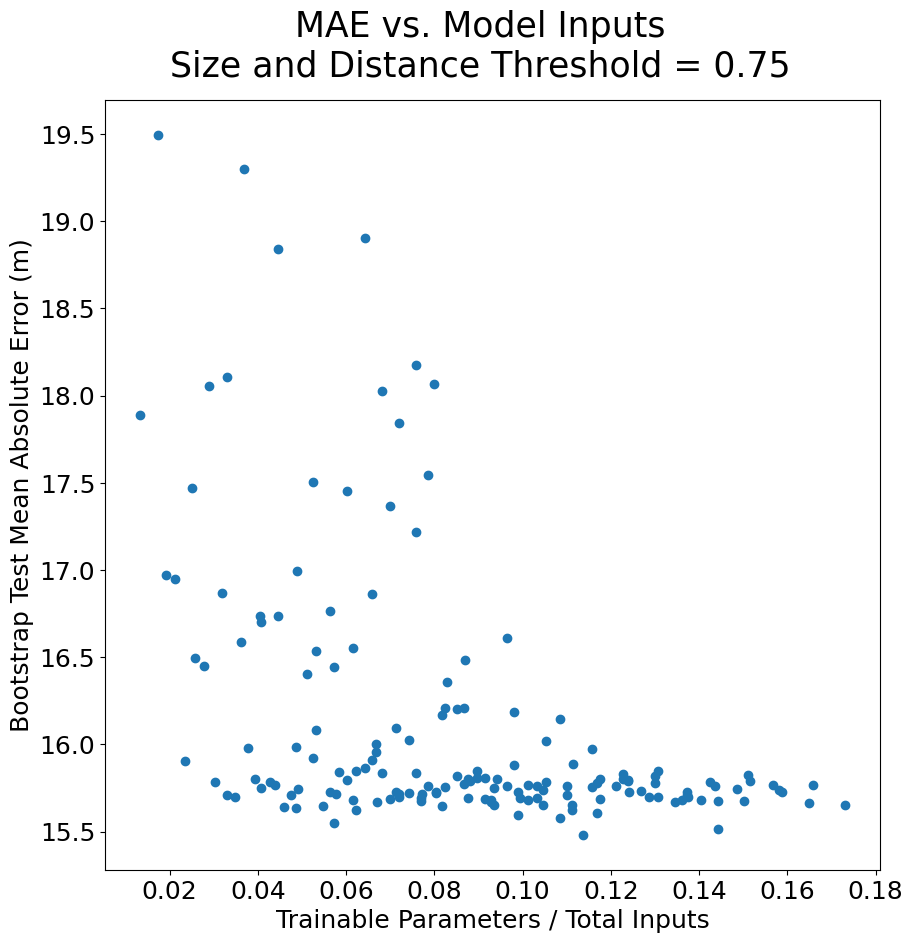

In [7]:
fig = plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('MAE vs. Model Inputs\n'+
             'Size and Distance Threshold = ' + threshold, fontsize = 25, y=.97
            )
# fig, ax = plt.subplots()
# ax = fig.add_subplot(111)
plt.scatter(
    stats1['parameter ratio'],
    stats1['test mae avg']
)
# ax.grid(True)
# ax_second = ax.twinx() 
# ax_second.set_xticks(ax.get_yticks(), rotation = 45, 
#                     labels = statistics_mae['trained parameters'].iloc[ticks]
# )
# plt.scatter(
#     stats2['paramater ratio'],
#     stats2['test loss avg']
# )
plt.ylabel('Bootstrap Test Mean Absolute Error (m)', fontsize = 18)
plt.xlabel('Trainable Parameters / Total Inputs', fontsize = 18)
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 18)
fig.patch.set_facecolor('w')

# plt.yscale('log')
plt.show()
# plt.savefig('figs/elbow/75.png')

In [17]:
stats1[stats1['layer architecture'] == '10-5'].index

Index([55], dtype='int64')

10-5


/tmp/ipykernel_4175920/838742353.py:23: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(5,5,n+1)


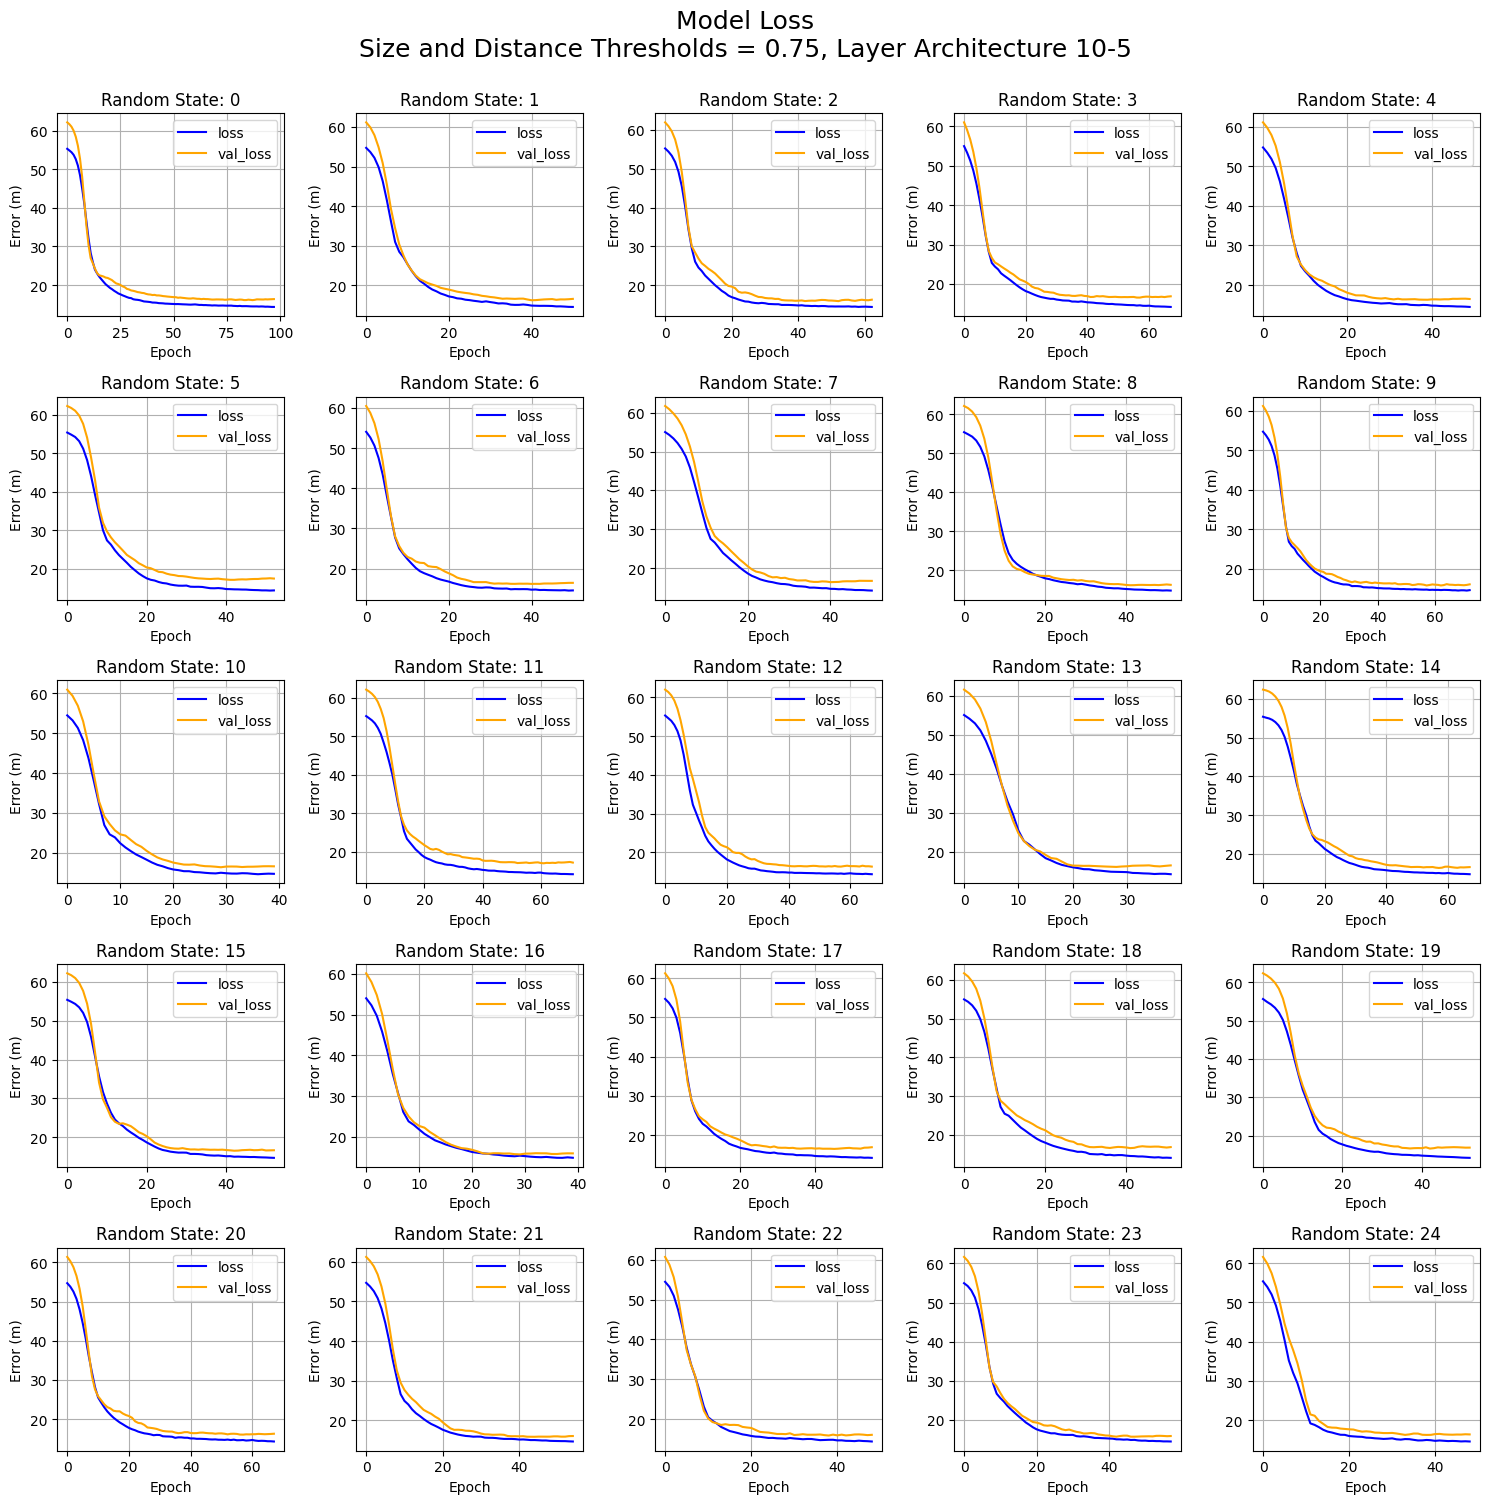

In [26]:
# load selected model and look at predicted accuracies of each random state
# print('Please select index from statistics table to inspect further')

# selection = int(input())
selection = 55
arch = stats1['layer architecture'].loc[selection]


print(arch)

rootdir_1 = 'saved_results/' + parameterization + '/' + arch + '/'
# print(rootdir_1)
dnn_history = {}
fig,ax=plt.subplots(1,1,figsize=(15,15))
fig.patch.set_facecolor('w')
plt.suptitle(
    'Model Loss\nSize and Distance Thresholds = ' + str(threshold) +
    ', Layer Architecture ' + str(arch) , fontsize=18, y=1
            )


for n, rs in enumerate(RS): 
    ax = plt.subplot(5,5,n+1)
    history_name = (

        str(rs)
    )

    model_name = (

        str(rs)
    )

    dnn_history[model_name] = pd.read_csv(rootdir_1 + model_name)

    ax.set_title('Random State: ' + str(rs))
#     ax.set_yscale('log')
    gl.plot_loss(dnn_history[model_name])
plt.tight_layout()

In [24]:
model_name

'0'

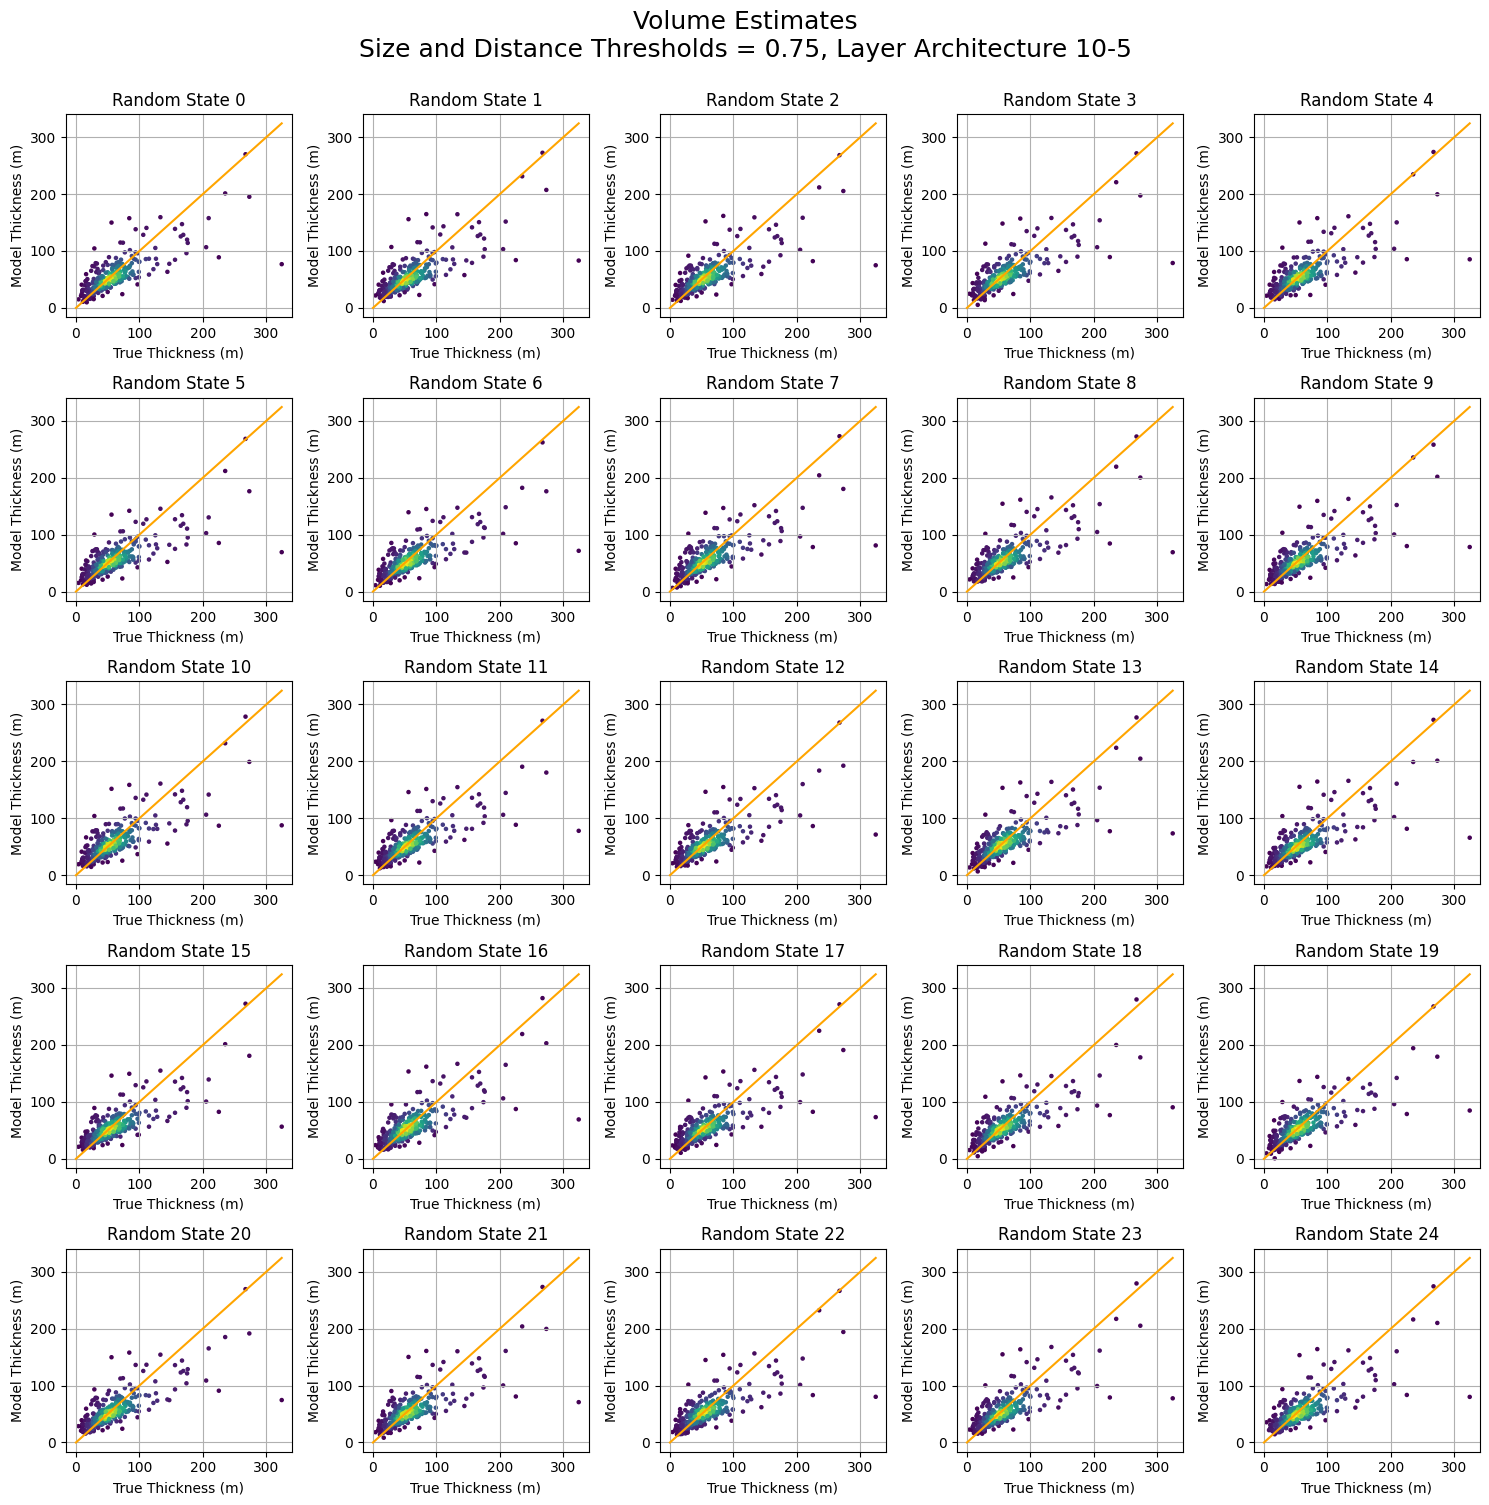

In [31]:
dnn_model = {}
rootdir_2 = 'saved_models/' + parameterization + '/' + arch + '/'
data = dataset.drop('RGIId', axis = 1)
train_features, test_features, train_labels, test_labels = gl.split_data(data)
features = pd.concat([train_features, test_features], ignore_index = True)
labels = pd.concat([train_labels, test_labels], ignore_index = True)

fig = plt.figure(figsize=(15, 15))
plt.subplots_adjust(hspace=0.5)
plt.suptitle(
    'Volume Estimates\nSize and Distance Thresholds = ' + threshold +
    ', Layer Architecture ' + arch , fontsize=18, y=1
            )
fig.patch.set_facecolor('w')

estimates = pd.DataFrame()
for n, rs in (enumerate(RS)):
    ax = plt.subplot(5, 5, n + 1)
    model_name = (
        str(rs)
    )   

    model_history = (
        str(rs) 
    )  

    model_path = (
        rootdir_2 + 
        str(rs)
    )

    dnn_model[model_name] = tf.keras.models.load_model(model_path)
    dnn_history[model_name] = pd.read_csv(rootdir_1 + model_history)

#     if abs((
#         dnn_history[model_name]['loss'].iloc[-1]
#     ) - dnn_history[model_name]['val_loss'].iloc[-1]) >= 3:
#         pass
#     else:
    y = dnn_model[model_name].predict(features, verbose = 0)

    x = labels
    y = y.flatten()

    xy = np.vstack([np.log10(x),np.log10(y)])

    z = gaussian_kde(xy)(xy)


    plt.scatter(
        x,
        y,
        marker = '.',
        c = (z),
        s = 20,
        cmap = 'viridis'
    )
    plt.plot(
        (0,labels.max()),
        (0,labels.max()),
        '-',
        color = 'orange'    
    )
    plt.xlabel('True Thickness (m)')
    plt.ylabel('Model Thickness (m)')
    ax.set_title('Random State ' +str(rs))
    ax.grid()
#         plt.xlim((0,100))
#         plt.ylim((0,100))
    estimates = pd.concat([estimates, pd.Series(y.flatten())], axis = 1)
plt.tight_layout()
plt.show()

In [ ]:
residuals = np.nanmean(estimates) - labels

In [ ]:
residuals

In [ ]:
plt.figure(figsize = (10,10))
plt.hist(residuals - labels, 20)
plt.xlabel('Thickness Difference')
plt.ylabel('Number of Elements')
plt.title('Histogram of Model Residuals')
mean = (estimates.mean() - labels).mean()
med = (estimates.mean() - labels).median()
mode = (estimates.mean() - labels).mode()
# plt.title('Log Percent Difference of Edasi & Lipovsky and Farinotti Glacier Volume')
# plt.axvline(mean, color='k', linestyle='dashed', linewidth=1)
# # plt.text(mean, 'Mean: {:.2f}'.format(mean))

# plt.axvline(med, color='k', linestyle='dashed', linewidth=1)
# # plt.text(med, 'Median: {:.2f}'.format(med))
# plt.axvline(mode[0], color='k', linestyle='dashed', linewidth=1)
# # plt.text((mode[0]), 'Mode: ' + str(np.round(mode[0], 2)))